Dataset Overview:
       Dimensions.Height  Dimensions.Length  Dimensions.Width  \
count        5076.000000        5076.000000       5076.000000   
mean          145.632191         127.825847        144.012411   
std            62.125026          77.358295         79.925899   
min             1.000000           2.000000          1.000000   
25%           104.000000          60.000000         62.000000   
50%           152.000000         128.000000        158.000000   
75%           193.000000         198.000000        219.000000   
max           255.000000         255.000000        254.000000   

       Engine Information.Number of Forward Gears  Fuel Information.City mpg  \
count                                 5076.000000                5076.000000   
mean                                     5.519110                  17.275808   
std                                      0.845637                   4.479485   
min                                      4.000000                   8.000000

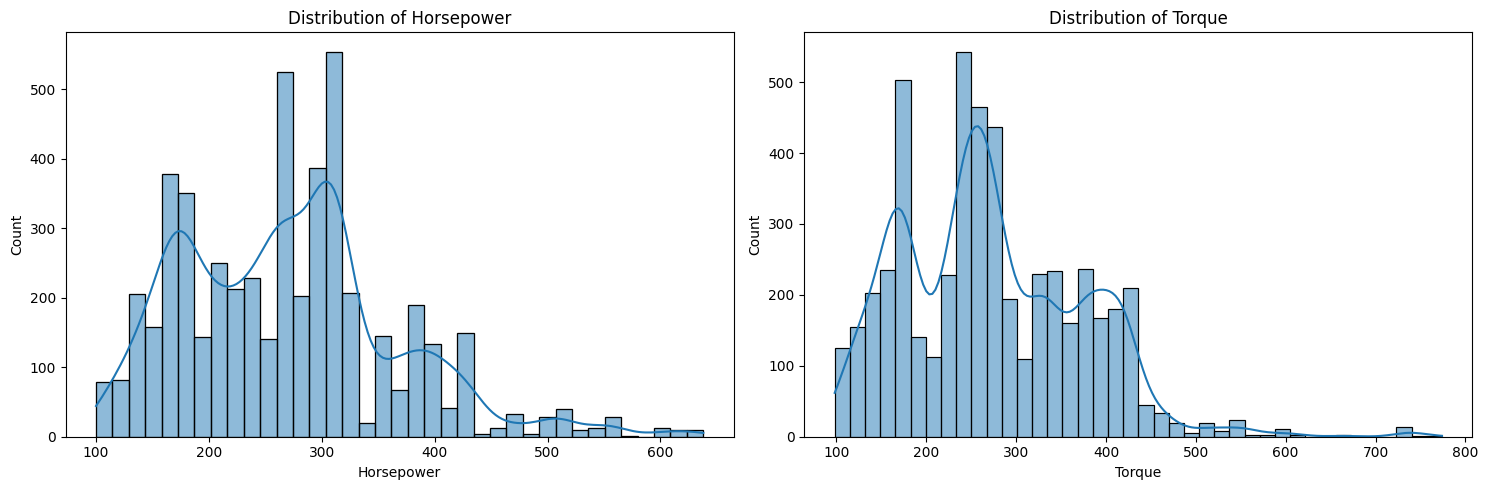

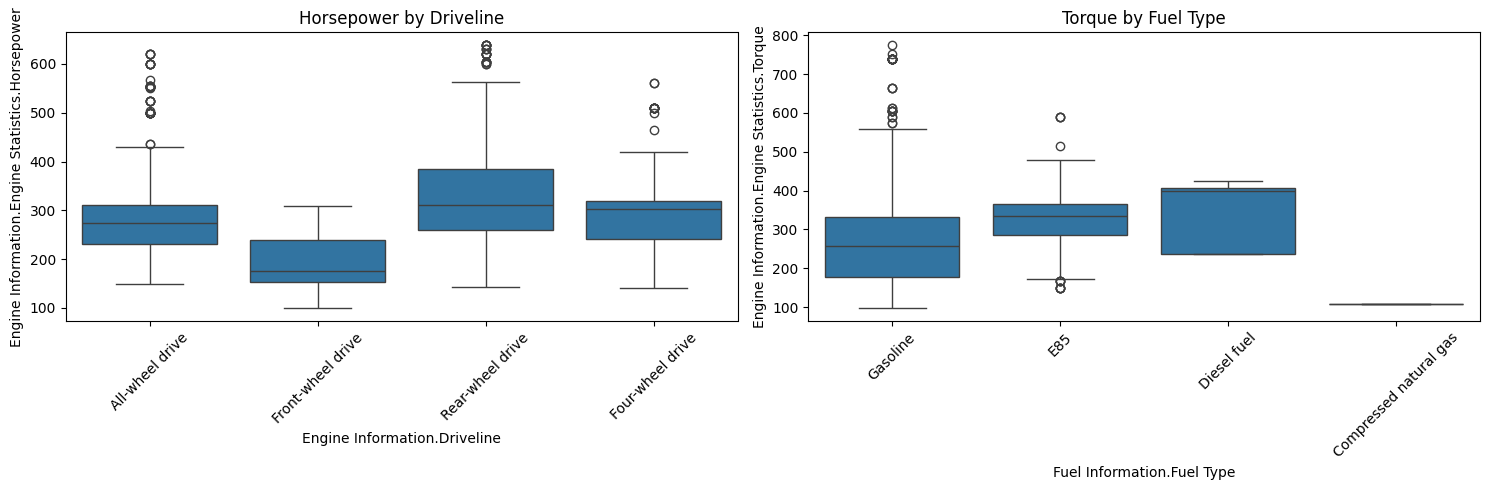

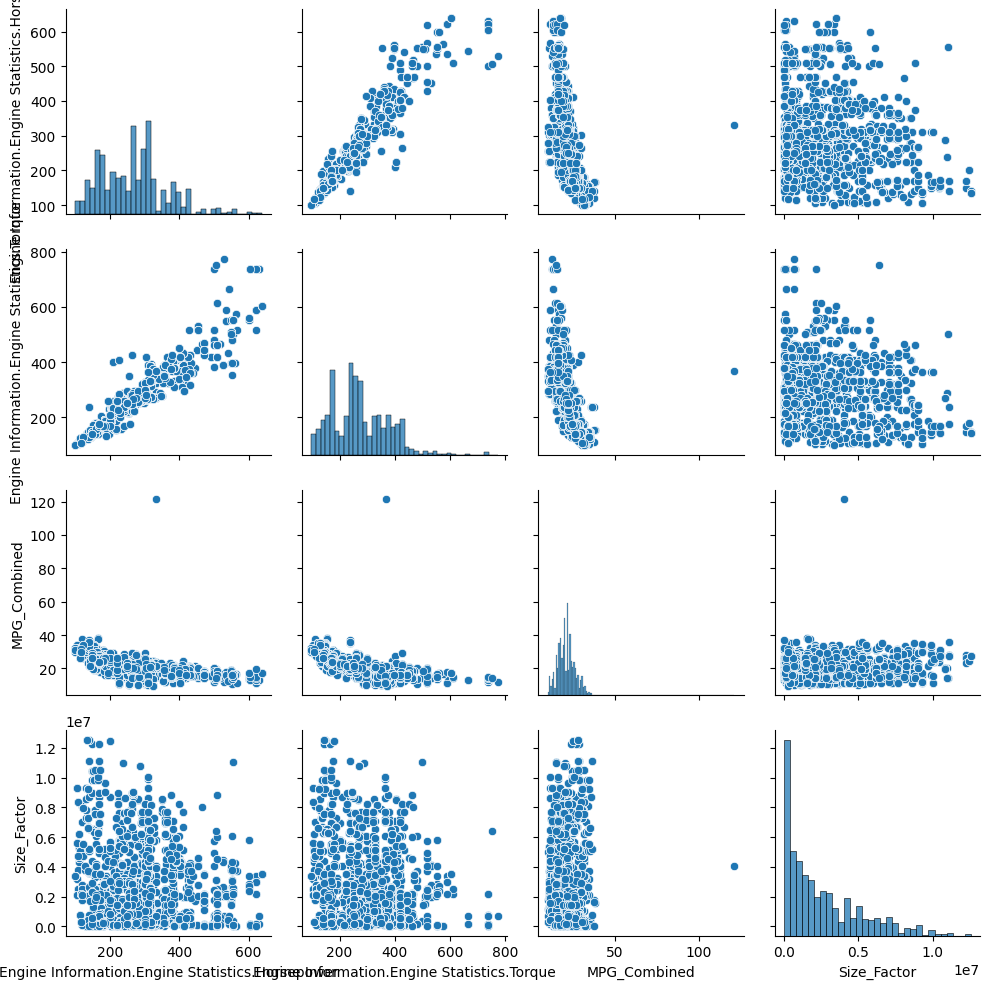

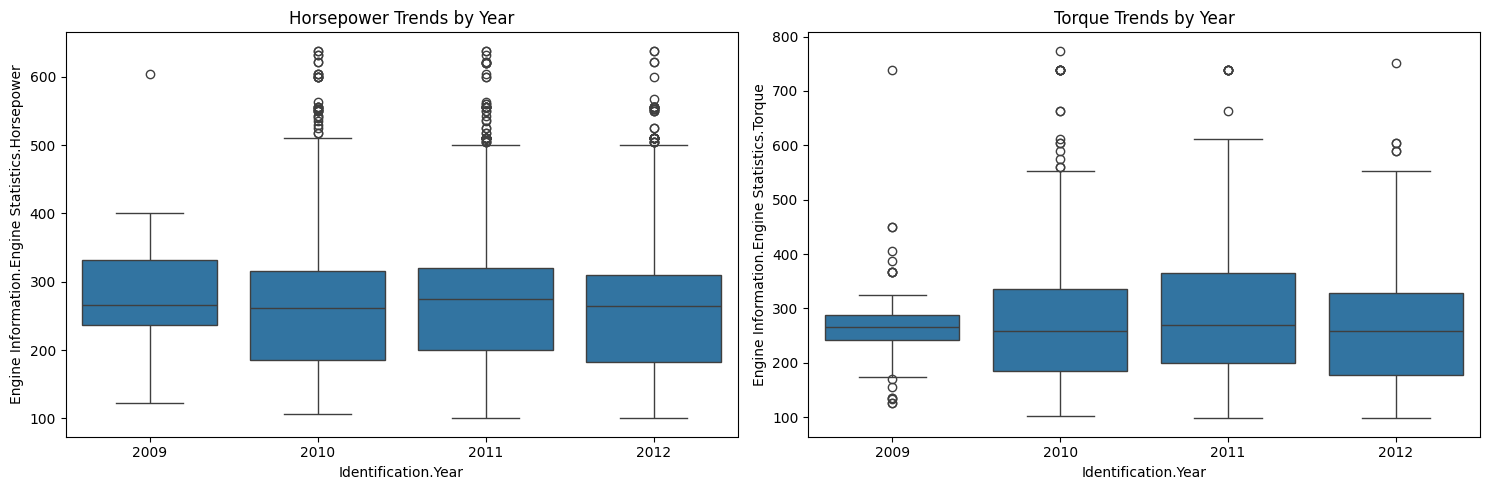

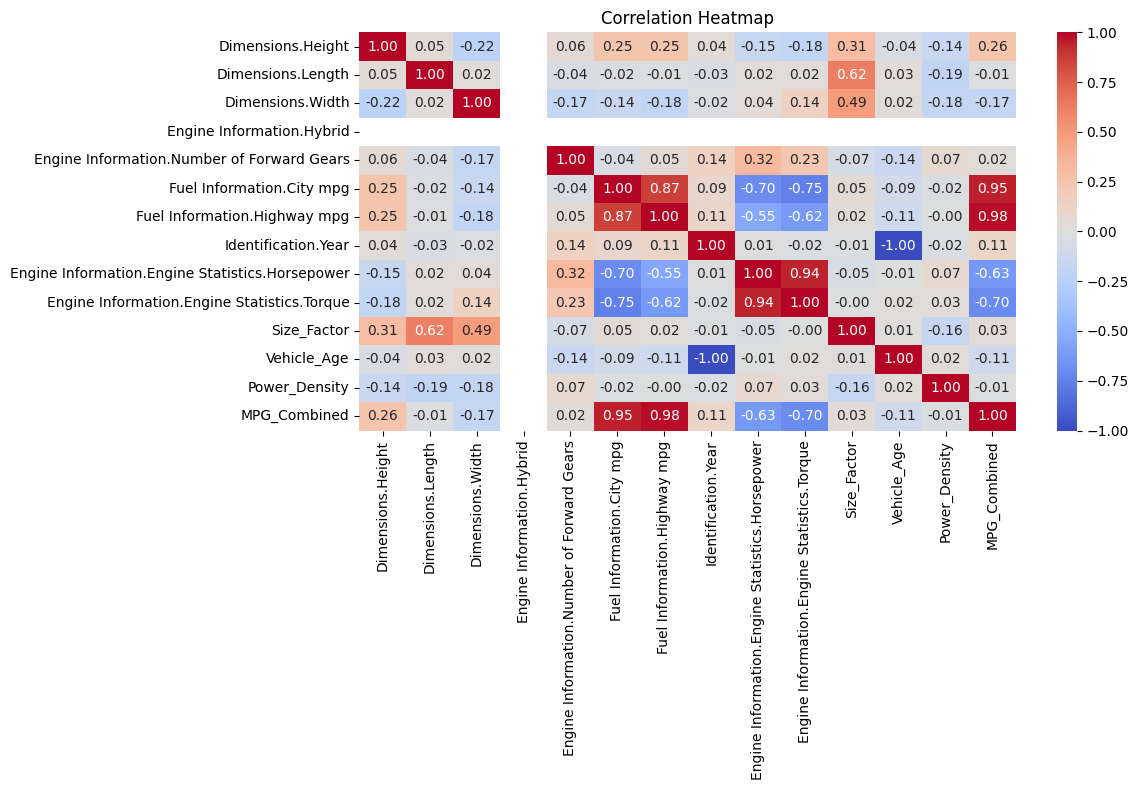


VIF Scores for Numerical Features:
                                      Feature       VIF
6                                 Size_Factor  2.953502
1                           Dimensions.Length  2.035713
2                            Dimensions.Width  1.836642
0                           Dimensions.Height  1.525590
8                               Power_Density  1.192194
3  Engine Information.Number of Forward Gears  1.175091
4                                MPG_Combined  1.104757
5                                 Vehicle_Age  1.059502
7                   Engine Information.Hybrid       NaN


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



Horsepower Prediction Results:
R² Score: 0.4271
RMSE: 68.78
Cross-validation R² scores: 0.4739 (+/- 0.6038)

Torque Prediction Results:
R² Score: 0.4496
RMSE: 70.24
Cross-validation R² scores: 0.5415 (+/- 0.4602)


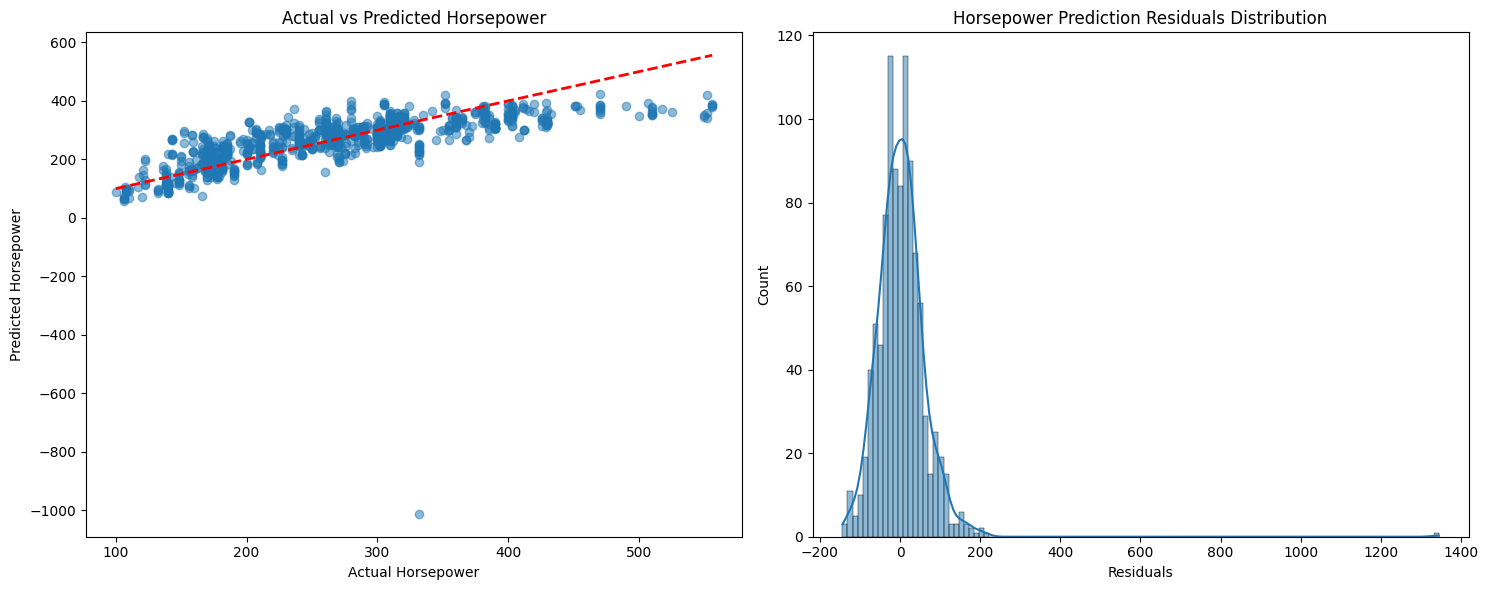

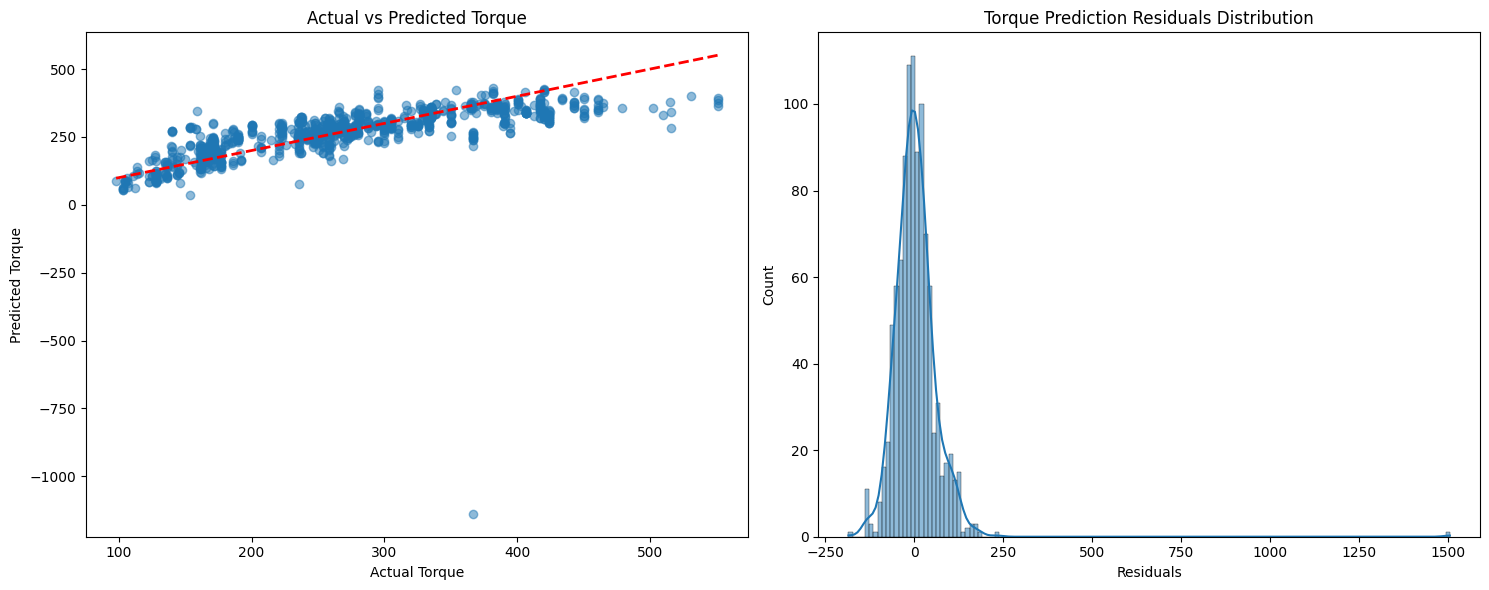


Top 10 Most Important Features for Horsepower:
                                              Feature  Coefficient
4                                        MPG_Combined   -87.076884
15                     Fuel Information.Fuel Type_E85   -40.920399
12      Engine Information.Driveline_Rear-wheel drive    27.585379
16                Fuel Information.Fuel Type_Gasoline    27.350609
3          Engine Information.Number of Forward Gears    27.137710
21     Engine Information.Transmission_5 Speed Manual   -18.916109
24     Engine Information.Transmission_6 Speed Manual    18.815215
13  Fuel Information.Fuel Type_Compressed natural gas    18.491301
11     Engine Information.Driveline_Front-wheel drive   -14.178547
17  Engine Information.Transmission_4 Speed Automatic   -14.142050


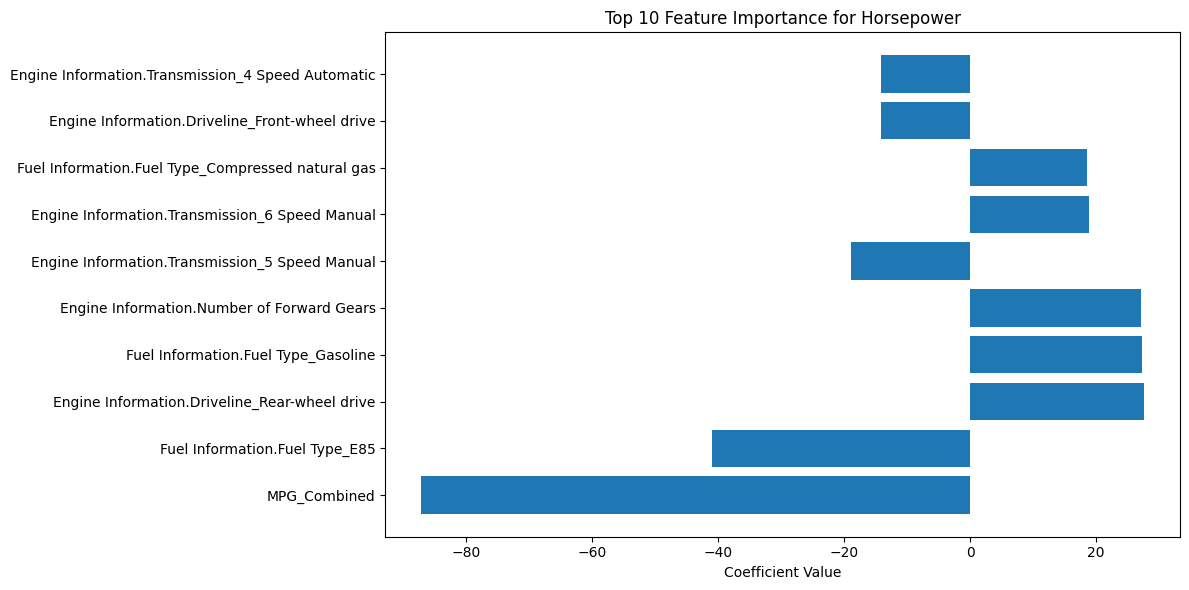


Top 10 Most Important Features for Torque:
                                              Feature  Coefficient
14             Fuel Information.Fuel Type_Diesel fuel   125.836118
4                                        MPG_Combined   -97.210948
15                     Fuel Information.Fuel Type_E85   -82.904571
13  Fuel Information.Fuel Type_Compressed natural gas   -30.444933
12      Engine Information.Driveline_Rear-wheel drive    26.830544
27  Engine Information.Transmission_8 Speed Automa...    26.384348
26  Engine Information.Transmission_7 Speed Automa...   -22.969012
25  Engine Information.Transmission_7 Speed Automatic   -22.759553
3          Engine Information.Number of Forward Gears    21.528492
21     Engine Information.Transmission_5 Speed Manual   -19.635711


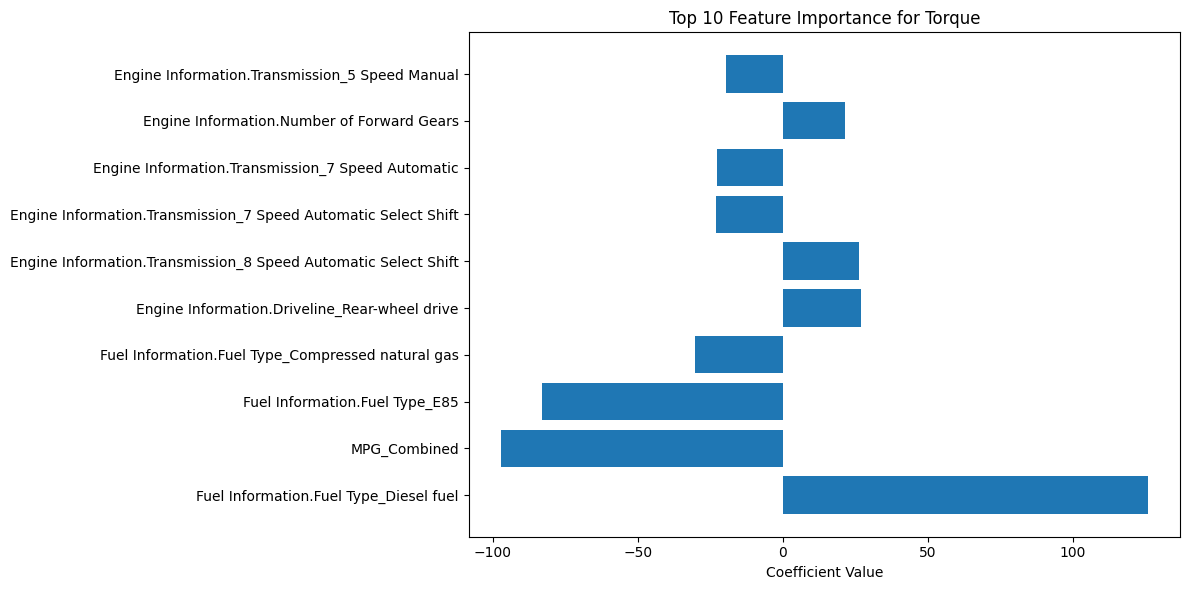

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Reading the dataset
data = pd.read_csv('cars.csv')
df = pd.DataFrame(data)

# Basic data exploration
print("Dataset Overview:")
print(df.describe())
print('\nShape =', df.shape)
print('Number of duplicated values:', df.duplicated().sum())

# Remove duplicates
df.drop_duplicates(inplace=True)
print('\nDuplicates Removed')
print('Remaining duplicates:', df.duplicated().sum())

# Check for missing values
print('\nMissing Values:')
print(df.isnull().sum())

# Feature Engineering
df['Size_Factor'] = df['Dimensions.Length'] * df['Dimensions.Width'] * df['Dimensions.Height']
df['Vehicle_Age'] = 2025 - df['Identification.Year']
df['Power_Density'] = df['Engine Information.Engine Statistics.Horsepower'] / df['Size_Factor']
df['MPG_Combined'] = (df['Fuel Information.Highway mpg'] + df['Fuel Information.City mpg']) / 2

# Convert hybrid to binary
df['Engine Information.Hybrid'] = df['Engine Information.Hybrid'].map({True: 1, False: 0})

# EDA Visualizations
# 1. Distribution plots for target variables
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Engine Information.Engine Statistics.Horsepower'], kde=True)
plt.title('Distribution of Horsepower')
plt.xlabel('Horsepower')

plt.subplot(1, 2, 2)
sns.histplot(df['Engine Information.Engine Statistics.Torque'], kde=True)
plt.title('Distribution of Torque')
plt.xlabel('Torque')

plt.tight_layout()
plt.show()

# 2. Box plots for categorical relationships
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='Engine Information.Driveline',
            y='Engine Information.Engine Statistics.Horsepower',
            data=df)
plt.xticks(rotation=45)
plt.title('Horsepower by Driveline')

plt.subplot(1, 2, 2)
sns.boxplot(x='Fuel Information.Fuel Type',
            y='Engine Information.Engine Statistics.Torque',
            data=df)
plt.xticks(rotation=45)
plt.title('Torque by Fuel Type')

plt.tight_layout()
plt.show()

# 3. Scatter plot matrix for key numerical features
numerical_features = [
    'Engine Information.Engine Statistics.Horsepower',
    'Engine Information.Engine Statistics.Torque',
    'MPG_Combined',
    'Size_Factor'
]

sns.pairplot(df[numerical_features])
plt.tight_layout()
plt.show()

# 4. Year-wise trends
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='Identification.Year',
            y='Engine Information.Engine Statistics.Horsepower',
            data=df)
plt.title('Horsepower Trends by Year')

plt.subplot(1, 2, 2)
sns.boxplot(x='Identification.Year',
            y='Engine Information.Engine Statistics.Torque',
            data=df)
plt.title('Torque Trends by Year')

plt.tight_layout()
plt.show()

# 5. Correlation heatmap for numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Remove outliers
def remove_outliers(df, column, n_std):
    mean = df[column].mean()
    std = df[column].std()
    return df[abs(df[column] - mean) <= (n_std * std)]

df = remove_outliers(df, 'Engine Information.Engine Statistics.Horsepower', 3)
df = remove_outliers(df, 'Engine Information.Engine Statistics.Torque', 3)

# One-hot encode categorical variables
categorical_columns = [
    'Engine Information.Driveline',
    'Fuel Information.Fuel Type',
    'Engine Information.Transmission'
]

df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Select features for modeling
numerical_features = [
    'Dimensions.Height',
    'Dimensions.Length',
    'Dimensions.Width',
    'Engine Information.Number of Forward Gears',
    'MPG_Combined',
    'Vehicle_Age',
    'Size_Factor',
    'Engine Information.Hybrid',
    'Power_Density'
]

# Prepare feature matrix
X = df_encoded[numerical_features +
    [col for col in df_encoded.columns if any(x in col for x in categorical_columns)]]

# Scale numerical features
scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

# Check VIF scores before modeling
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

# Calculate VIF for numerical features
X_numeric = X_scaled[numerical_features]
print("\nVIF Scores for Numerical Features:")
print(calculate_vif(X_numeric))

# Prepare target variables
y_horsepower = df_encoded['Engine Information.Engine Statistics.Horsepower']
y_torque = df_encoded['Engine Information.Engine Statistics.Torque']

# Split data for horsepower prediction
X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(
    X_scaled, y_horsepower, test_size=0.2, random_state=42
)

# Train horsepower model
hp_model = LinearRegression()
hp_model.fit(X_train_hp, y_train_hp)

# Make horsepower predictions
y_pred_hp = hp_model.predict(X_test_hp)

# Evaluate horsepower model
r2_hp = r2_score(y_test_hp, y_pred_hp)
rmse_hp = np.sqrt(mean_squared_error(y_test_hp, y_pred_hp))
cv_scores_hp = cross_val_score(hp_model, X_scaled, y_horsepower, cv=5, scoring='r2')

print("\nHorsepower Prediction Results:")
print(f"R² Score: {r2_hp:.4f}")
print(f"RMSE: {rmse_hp:.2f}")
print(f"Cross-validation R² scores: {cv_scores_hp.mean():.4f} (+/- {cv_scores_hp.std() * 2:.4f})")

# Split data for torque prediction
X_train_tq, X_test_tq, y_train_tq, y_test_tq = train_test_split(
    X_scaled, y_torque, test_size=0.2, random_state=42
)

# Train torque model
torque_model = LinearRegression()
torque_model.fit(X_train_tq, y_train_tq)

# Make torque predictions
y_pred_tq = torque_model.predict(X_test_tq)

# Evaluate torque model
r2_tq = r2_score(y_test_tq, y_pred_tq)
rmse_tq = np.sqrt(mean_squared_error(y_test_tq, y_pred_tq))
cv_scores_tq = cross_val_score(torque_model, X_scaled, y_torque, cv=5, scoring='r2')

print("\nTorque Prediction Results:")
print(f"R² Score: {r2_tq:.4f}")
print(f"RMSE: {rmse_tq:.2f}")
print(f"Cross-validation R² scores: {cv_scores_tq.mean():.4f} (+/- {cv_scores_tq.std() * 2:.4f})")

# Feature importance analysis
def display_feature_importance(model, feature_names, target_name):
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)

    print(f"\nTop 10 Most Important Features for {target_name}:")
    print(coefficients.head(10))

    # Visualize feature importance
    plt.figure(figsize=(12, 6))
    plt.barh(coefficients['Feature'][:10], coefficients['Coefficient'][:10])
    plt.title(f'Top 10 Feature Importance for {target_name}')
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.show()

# Actual vs Predicted Plots
# Horsepower
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_hp, y_pred_hp, alpha=0.5)
plt.plot([y_test_hp.min(), y_test_hp.max()], [y_test_hp.min(), y_test_hp.max()], 'r--', lw=2)
plt.xlabel('Actual Horsepower')
plt.ylabel('Predicted Horsepower')
plt.title('Actual vs Predicted Horsepower')

plt.subplot(1, 2, 2)
residuals_hp = y_test_hp - y_pred_hp
sns.histplot(residuals_hp, kde=True)
plt.xlabel('Residuals')
plt.title('Horsepower Prediction Residuals Distribution')

plt.tight_layout()
plt.show()

# Torque
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_tq, y_pred_tq, alpha=0.5)
plt.plot([y_test_tq.min(), y_test_tq.max()], [y_test_tq.min(), y_test_tq.max()], 'r--', lw=2)
plt.xlabel('Actual Torque')
plt.ylabel('Predicted Torque')
plt.title('Actual vs Predicted Torque')

plt.subplot(1, 2, 2)
residuals_tq = y_test_tq - y_pred_tq
sns.histplot(residuals_tq, kde=True)
plt.xlabel('Residuals')
plt.title('Torque Prediction Residuals Distribution')

plt.tight_layout()
plt.show()

display_feature_importance(hp_model, X.columns, "Horsepower")
display_feature_importance(torque_model, X.columns, "Torque")